<a href="https://colab.research.google.com/github/crowetc/Random_Projects/blob/master/EuroSat_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Land Use Classifier with EuroSat Dataset**

This project creates a convolutional neural network to classify land uses from the EuroSat dataset. It explores different methods for saving model weights during training.

#### The EuroSAT dataset

This classifier uses the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

The train and test datasets used for this project can be downloaded from the following links:

x_train: https://drive.google.com/open?id=1cUaIEd9-MLJHFGjLz5QziNvfBtYygplX

y_train: https://drive.google.com/open?id=1hv24Ufiio9rBeSqgnNoM3dr5sVGwOmBy

x_test: https://drive.google.com/open?id=1AH9lKHT5P2oQLz8SGMRPWs_M9wIM2ZRH

y_test: https://drive.google.com/open?id=1i4_azocSDuU3TcDf3OSHO1vF0D5-xMU6

In [148]:
# Import Packages

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [92]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [93]:
# Import the EuroSat data from Google Drive

def load_eurosat_data():
    x_train = np.load('./gdrive/My Drive/Colab_Notebooks/EuroSat/data/x_train.npy')
    y_train = np.load('./gdrive/My Drive/Colab_Notebooks/EuroSat/data/y_train.npy')
    x_test  = np.load('./gdrive/My Drive/Colab_Notebooks/EuroSat/data/x_test.npy')
    y_test  = np.load('./gdrive/My Drive/Colab_Notebooks/EuroSat/data/y_test.npy')
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_eurosat_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [94]:
# Define get_new_model function

def get_new_model(input_shape):
  model = Sequential([
      Conv2D(32, (3,3), padding='SAME', activation='relu',
             input_shape=input_shape, name='conv_1'),
      MaxPooling2D((2,2), name='pool_1'),
      BatchNormalization(name='batch_norm_1'),
      Conv2D(16, (3,3), padding='SAME', activation='relu', name='conv_2'),
      MaxPooling2D((2,2), name='pool_2'),
      BatchNormalization(name='batch_norm_2'),
      Conv2D(8, (3,3), padding='SAME', activation='relu', name='conv_3'),
      MaxPooling2D((2,2), name='pool_3'),
      BatchNormalization(name='batch_norm_3'),
      Conv2D(8, (3,3), padding='SAME', activation='relu', name='conv_4'),
      MaxPooling2D((2,2), name='pool_4'),
      BatchNormalization(name='batch_norm_4'),
      Flatten(name='flatten'),
      Dense(32, activation='relu', name='dense_1'),
      Dense(10, activation='softmax', name='dense_2')
  ])

  model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return model

In [95]:
# Define get_test_accuracy function

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [96]:
# Generate model and test untrained accuracy
model = get_new_model(x_train[0].shape)
model.summary()
get_test_accuracy(model, x_test, y_test)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 32, 32, 32)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 16)        4624      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 16, 16, 16)        0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 16, 16, 16)        64        
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 8)        

In [97]:
# Define checkpoint functions

def get_checkpoint_every_epoch():
  """
  This function returns a ModelCheckpoint object that:
  - saves the weights only at the end of every epoch
  - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
  - generates filenames in that directory like 'checkpoint_XXX' where
    XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
  """
  checkpoint_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'
  checkpoint = ModelCheckpoint(checkpoint_path,
                               save_weights_only=True,
                               save_freq='epoch',
                               verbose=1)
  return checkpoint

def get_checkpoint_best_only():
    """
    This function returns a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    checkpoint_path = 'checkpoints_best_only/checkpoint'
    checkpoint = ModelCheckpoint(checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)
    return checkpoint

In [98]:
# Define early_stopping function

def get_early_stopping():
  """
  This function returns an EarlyStopping callback that stops training when
  the validation (testing) accuracy has not improved in 3 epochs.
  """
  early_stopping = EarlyStopping(
    monitor='accuracy', min_delta=0, patience=3, verbose=1, mode='max',
  )

  return early_stopping

In [99]:
# Generate Callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

In [100]:
# Train model with callbacks

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
call_history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 1.5560 - accuracy: 0.4410
Epoch 00001: saving model to checkpoints_every_epoch/checkpoint_001

Epoch 00001: val_loss improved from inf to 2.70182, saving model to checkpoints_best_only/checkpoint
125/125 [==============================] - 20s 156ms/step - loss: 1.5560 - accuracy: 0.4410 - val_loss: 2.7018 - val_accuracy: 0.1060
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 1.1116 - accuracy: 0.5975
Epoch 00002: saving model to checkpoints_every_epoch/checkpoint_002

Epoch 00002: val_loss did not improve from 2.70182
125/125 [==============================] - 19s 154ms/step - loss: 1.1116 - accuracy: 0.5975 - val_loss: 3.5115 - val_accuracy: 0.1060
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.6582
Epoch 00003: saving model to checkpoints_every_epoch/checkpoint_003

Epoch 00003: val_loss did not improve from 2.70182
125/125 [=========================

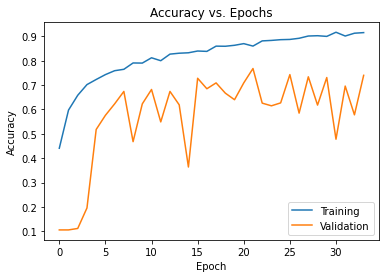

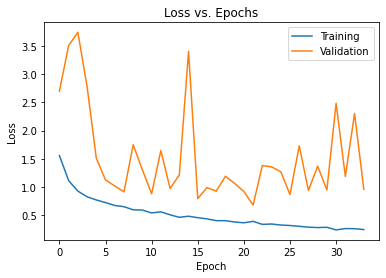

In [101]:
# Plot Learning Curves

# Accuracy vs Epochs
try:
    plt.plot(call_history.history['accuracy'])
    plt.plot(call_history.history['val_accuracy'])
except KeyError:
    plt.plot(call_history.history['acc'])
    plt.plot(call_history.history['val_acc'])
plt.title('Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

# Loss vs Epochs
plt.plot(call_history.history['loss'])
plt.plot(call_history.history['val_loss'])
plt.title('Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [144]:
# Define functions to generate model with saved weights

def get_model_last_epoch(model):
  """
  This function creates a new instance of the CNN created earlier,
  loads the weights from the last training epoch, and returns the model
  """
  max_epoch = len(call_history.history['loss'])
  checkpoint_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'.format(epoch=max_epoch)
  model.load_weights(checkpoint_path)
  return model


def get_model_best_epoch(model):
  """
  This function creates a new instance of the CNN created earlier, loads
  the weights that led to the highest validation accuracy, and returns the model
  """
  checkpoint_path = 'checkpoints_best_only/checkpoint'
  model.load_weights(checkpoint_path)
  return model

In [110]:
! ls -lh checkpoints_every_epoch/

total 5.4M
-rw-r--r-- 1 root root   85 Jul 16 18:49 checkpoint
-rw-r--r-- 1 root root 149K Jul 16 18:38 checkpoint_001.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:38 checkpoint_001.index
-rw-r--r-- 1 root root 149K Jul 16 18:38 checkpoint_002.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:38 checkpoint_002.index
-rw-r--r-- 1 root root 149K Jul 16 18:39 checkpoint_003.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:39 checkpoint_003.index
-rw-r--r-- 1 root root 149K Jul 16 18:39 checkpoint_004.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:39 checkpoint_004.index
-rw-r--r-- 1 root root 149K Jul 16 18:39 checkpoint_005.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:39 checkpoint_005.index
-rw-r--r-- 1 root root 149K Jul 16 18:40 checkpoint_006.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 16 18:40 checkpoint_006.index
-rw-r--r-- 1 root root 149K Jul 16 18:40 checkpoint_007.data-00000-of-00001
-rw-r--r-- 1 root root 4.8K Jul 1

In [145]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one wiht the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))
print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, x_test, y_test)

Model with last epoch weights:
accuracy: 0.740

Model with best epoch weights:
accuracy: 0.768
